In [1]:
import torch
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt

from hydra import initialize, compose
from hydra.utils import instantiate

from case_studies.dc2_cataloging.utils.load_full_cat import get_full_cat

output_dir = Path("./flux_err_plot_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp/exp_06-16-2/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
_, test_image_full_cat, bliss_full_cat, lsst_full_cat = get_full_cat(notebook_cfg, 
                                                                    0, 
                                                                    model_path, 
                                                                    lsst_root_dir, 
                                                                    device)

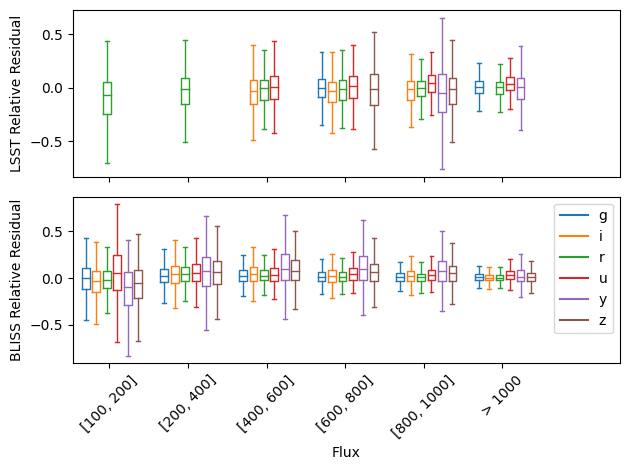

In [4]:
matcher = instantiate(notebook_cfg.encoder.matcher)
bliss_matching = matcher.match_catalogs(test_image_full_cat, bliss_full_cat)[0]
lsst_matching = matcher.match_catalogs(test_image_full_cat, lsst_full_cat)[0]

flux_bin_cutoffs = torch.tensor([200, 400, 600, 800, 1000])
n_flux_bins = flux_bin_cutoffs.shape[0] + 1
bands = ("g", "i", "r", "u", "y", "z")
bands_color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"][0:len(bands)]

true_flux = test_image_full_cat.on_fluxes[0, bliss_matching[0], :]
bucketized_true_flux = torch.bucketize(true_flux, flux_bin_cutoffs)
bliss_flux = bliss_full_cat.on_fluxes[0, bliss_matching[1], :]
flux_err = (true_flux - bliss_flux) / true_flux
bliss_flux_err_flux_bin_dict = {i: [] for i in bands}

for band_idx, band_name in enumerate(bands):
    for flux_bin_idx in range(n_flux_bins):
        bliss_flux_err_flux_bin_dict[band_name].append(
            flux_err[bucketized_true_flux[:, band_idx] == flux_bin_idx, band_idx].tolist()
            )

true_flux = test_image_full_cat.on_fluxes[0, lsst_matching[0], :]
bucketized_true_flux = torch.bucketize(true_flux, flux_bin_cutoffs)
lsst_flux = lsst_full_cat.on_fluxes[0, lsst_matching[1], :]
flux_err = (true_flux - lsst_flux) / true_flux
lsst_flux_err_flux_bin_dict = {i: [] for i in bands}

for band_idx, band_name in enumerate(bands):
    for flux_bin_idx in range(n_flux_bins):
        lsst_flux_err_flux_bin_dict[band_name].append(
            flux_err[bucketized_true_flux[:, band_idx] == flux_bin_idx, band_idx].tolist()
            )

xlabels = (
    ["[100, " + str(flux_bin_cutoffs[0].item()) + "]"]
    + [f"[{flux_bin_cutoffs[i].item()}, {flux_bin_cutoffs[i + 1].item()}]" for i in range(len(flux_bin_cutoffs) - 1)]
    + ["> " + str(flux_bin_cutoffs[-1].item())]
)

def set_box_color(bp, color):
    plt.setp(bp["boxes"], color=color)
    plt.setp(bp["whiskers"], color=color)
    plt.setp(bp["caps"], color=color)
    plt.setp(bp["medians"], color=color)

fig, axes = plt.subplots(2, 1, sharex="col")

for i, (k, v) in enumerate(bliss_flux_err_flux_bin_dict.items()):
    bp = axes[1].boxplot(v, positions=np.array(list(range(len(v)))) * 3 + 0.4 * i, sym="", widths=0.3)
    set_box_color(bp, bands_color_list[i])
    axes[1].plot([], c=bands_color_list[i], label=k)

axes[1].set_ylabel("BLISS Relative Residual")

for i, (k, v) in enumerate(lsst_flux_err_flux_bin_dict.items()):
    bp = axes[0].boxplot(v, positions=np.array(list(range(len(v)))) * 3 + 0.4 * i, sym="", widths=0.3)
    set_box_color(bp, bands_color_list[i])

axes[0].set_ylabel("LSST Relative Residual")
axes[0].set_xticks(np.array(list(range(len(bands)))) * 3 + 0.9)
axes[1].set_xticklabels(xlabels, rotation=45)
axes[0].set_xlim(-0.5, n_flux_bins * 3 + 0.4 * len(bands))
axes[1].set_xlabel("Flux")

plt.legend()
plt.grid(visible=False, axis="x")
plt.tight_layout()
plt.show()